# Classification du Diagnostic de Performance Énergétique (DPE)

Ce notebook a pour objectif de développer un modèle de **classification supervisée**
permettant de prédire la **classe DPE (A à G)** d’un logement à partir de ses
caractéristiques physiques, énergétiques et techniques.

Ce travail s’inscrit dans le projet **IES**, visant à estimer la performance
énergétique d’un logement avant et après travaux de rénovation.

## Import des bibliothèques

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt
import joblib


## Chargement des données

Les données utilisées sont issues du fichier `DPE.csv`, préalablement nettoyé
et stocké dans le dossier `data/processed`.

In [36]:
df = pd.read_csv("../../data/features/DPE.csv")
df.head()

,type_batiment,type_installation_chauffage,type_installation_ecs,hauteur_sous_plafond,etiquette_dpe,etiquette_ges,surface_habitable_logement,nombre_niveau_logement,code_postal,isolation,cout_conso,conso_finale,conso_primaire,type_energie_principale
0,appartement,collectif,collectif,2.5,D,D,32.0,1.0,75013.0,insuffisante,564.9,7643.1,8248.7,Réseau de Chauffage urbain
1,appartement,individuel,individuel,2.5,E,B,74.2,1.0,54160.0,insuffisante,1664.0,9978.0,22949.4,Électricité
2,appartement,individuel,individuel,2.8,D,D,38.6,1.0,75007.0,insuffisante,731.0,7969.2,8350.1,Gaz naturel
3,maison,individuel,individuel,2.3,D,B,57.2,3.0,44390.0,bonne,1027.5,5932.8,13645.4,Électricité
4,appartement,individuel,individuel,2.5,D,B,32.2,1.0,93370.0,insuffisante,674.4,3639.9,8371.7,Électricité


## Exploration rapide du jeu de données

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   type_batiment                8700 non-null   object 
 1   type_installation_chauffage  8700 non-null   object 
 2   type_installation_ecs        8700 non-null   object 
 3   hauteur_sous_plafond         8700 non-null   float64
 4   etiquette_dpe                8700 non-null   object 
 5   etiquette_ges                8700 non-null   object 
 6   surface_habitable_logement   8700 non-null   float64
 7   nombre_niveau_logement       8700 non-null   float64
 8   code_postal                  8700 non-null   float64
 9   isolation                    8700 non-null   object 
 10  cout_conso                   8700 non-null   float64
 11  conso_finale                 8700 non-null   float64
 12  conso_primaire               8700 non-null   float64
 13  type_energie_princ

In [4]:
df["etiquette_dpe"].value_counts().sort_index()


etiquette_dpe
A      80
B     221
C    1849
D    2775
E    1987
F    1015
G     773
Name: count, dtype: int64

## Nettoyage et sélection des variables

- Suppression des lignes sans étiquette DPE
- Exclusion de `etiquette_ges` pour éviter toute fuite de label

In [49]:
df = df.dropna(subset=["etiquette_dpe"])

X = df.drop(columns=["etiquette_dpe", "etiquette_ges"])
y = df["etiquette_dpe"]

## Encodage de la variable cible

Les classes DPE (A à G) sont encodées sous forme numérique afin d’être utilisées
par les algorithmes de classification.


In [50]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

label_encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object)

## Séparation des données

Un découpage stratifié est utilisé afin de conserver la distribution
des classes DPE dans les ensembles d’entraînement et de test.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

## Préprocessing des données

- Variables numériques : standardisation
- Variables catégorielles : One-Hot Encoding

In [52]:
categorical_features = [
    "type_batiment",
    "type_installation_chauffage",
    "type_installation_ecs",
    "isolation",
    "type_energie_principale",
    "code_postal"
]

numerical_features = [
    "hauteur_sous_plafond",
    "surface_habitable_logement",
    "nombre_niveau_logement",
    "cout_conso",
    "conso_finale",
    "conso_primaire"
]


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

## Modèle de classification

Un modèle de type **XGBoost** est utilisé afin de capturer des relations
non linéaires entre les variables explicatives et la classe DPE.

In [53]:
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=7,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

## Pipeline de classification

Le pipeline combine le preprocessing et le modèle dans une seule chaîne
réutilisable et déployable.

In [54]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", xgb_model)
])

## Entraînement du modèle

In [55]:
xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Inférence du modèle

L'inférence permet de tester la capacité du modèle à prédire la classe
énergétique (DPE) d’un logement **jamais vu lors de l’entraînement**.

Cette étape simule un cas réel d’utilisation :  
un nouveau logement est décrit par ses caractéristiques, et le modèle
doit estimer sa classe DPE sans connaître la vérité terrain.

L’objectif ici n’est pas d’évaluer globalement les performances du modèle,
mais de vérifier :
- la cohérence de la prédiction
- la bonne prise en compte des variables
- la robustesse du pipeline de prétraitement + classification

In [56]:
# Exemple de logement jamais vu
nouveau_logement = pd.DataFrame([{
        "type_batiment": "maison",
        "type_installation_chauffage": "individuel",
        "type_installation_ecs": "individuel",
        "hauteur_sous_plafond": 2.6,
        "surface_habitable_logement": 100.0,
        "nombre_niveau_logement": 2.0,
        "code_postal": 38300.0,
        "isolation": "très bonne",
        "cout_conso": 721.4,
        "conso_finale": 3631.7,
        "conso_primaire": 8052.9,
        "type_energie_principale": "Électricité"
}])

In [57]:
# Prédiction de la classe DPE
prediction = xgb_pipeline.predict(nouveau_logement)

# Si LabelEncoder utilisé
classe_predite = label_encoder.inverse_transform(prediction)

print("Classe DPE prédite :", classe_predite[0])

Classe DPE prédite : B


## Évaluation des performances


In [58]:
y_pred = xgb_pipeline.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred,
        target_names=label_encoder.classes_
    )
)

              precision    recall  f1-score   support

           A       0.82      0.56      0.67        16
           B       0.70      0.64      0.67        44
           C       0.92      0.93      0.93       370
           D       0.91      0.94      0.93       555
           E       0.89      0.90      0.90       397
           F       0.84      0.82      0.83       203
           G       0.94      0.86      0.90       155

    accuracy                           0.90      1740
   macro avg       0.86      0.81      0.83      1740
weighted avg       0.90      0.90      0.90      1740



## Matrice de confusion

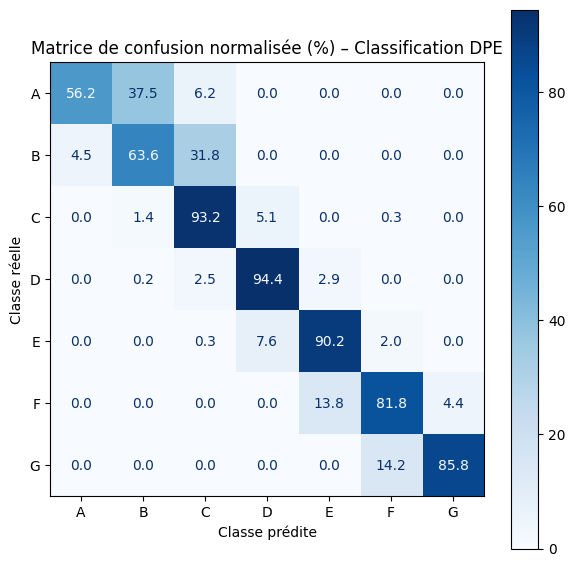

In [48]:
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_percent = cm_percent * 100

fig, ax = plt.subplots(figsize=(7, 7))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_percent,
    display_labels=label_encoder.classes_
)

disp.plot(
    ax=ax,
    cmap="Blues",
    values_format=".1f"
)

ax.set_title("Matrice de confusion normalisée (%) – Classification DPE")
ax.set_ylabel("Classe réelle")
ax.set_xlabel("Classe prédite")

plt.show()

## Validation croisée

La validation croisée permet d’évaluer la robustesse du modèle.

In [17]:
cv_scores = cross_val_score(
    xgb_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="f1_macro"
)

cv_scores.mean(), cv_scores.std()

print("Moyenne : ", cv_scores.mean())
print("Écart type : ", cv_scores.std())

Moyenne :  0.8493221295686391
Écart type :  0.01881369553957705


## Sauvegarde du pipeline

Le pipeline final est sauvegardé pour être réutilisé dans l’interface utilisateur
ou un backend d’inférence.

In [ ]:
BASE_DIR = Path.cwd().parent  # science/
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True)

joblib.dump(
    xgb_pipeline,
    MODEL_DIR / "dpe_classification_xgb.joblib"
)


with open(MODEL_DIR / "feature_columns.json", "w") as f:
    json.dump(
        {
            "numerical_features": numerical_features,
            "categorical_features": categorical_features
        },
        f,
        indent=4
    )